# Radial Basis Function #

References:
* http://www.jessebett.com/Radial-Basis-Function-USRA/
* http://scribblethink.org/Courses/ScatteredInterpolation/scatteredinterpcoursenotes.pdf

$$
f(x) = \sum_k^N{w_k\phi(\vert\vert{x-x_k}\vert\vert)}
$$

The conditions of interpolating the avaliable data can be written as

$$
f(x_i) = \sum_k^N{w_k\phi(\vert\vert{x_i-x_k}\vert\vert)} = f_i, 
\text{for } 1 \leq i \leq n
$$

This is a linear system of equations where the unknowns are the vector of weights ${w_k}$. To see this, let us call $\phi_{i,k} = \phi(\vert\vert{x_i-x_k}\vert\vert)$. We can then write the equivalent matrix representation of the interpolation conditions:

$$
\begin{bmatrix}
\phi_{1,1} & \phi_{1,2} & \phi_{1,3} & \dots \\ 
\phi_{2,1} & \phi_{2,2} & \dots \\
\phi_{3,1} & \dots \\
\vdots
\end{bmatrix}
\begin{bmatrix} 
w_1 \\
w_2 \\
w_3 \\
\vdots
\end{bmatrix} = 
\begin{bmatrix} 
f_1 \\
f_2 \\
f_3 \\
\vdots
\end{bmatrix}
$$

This is a square system with as many equations as unknowns. Thus we can
form the radial basis function interpolation by solving this system of equations

### Kernels ###

* Linear
$$
f(x) = \frac{1}{c}x
$$

* Inverse Multiquadric
$$
f(x) = \frac{1}{\sqrt{r^2+c^2}}
$$

* Gaussian
$$
f(x) = e^{-x^2/(2c^2)}
$$





In [5]:
import math
import numpy

def linear(value, sigma=1.0):
    return (sigma-numpy.clip(value, 0, sigma))/sigma

def gaussian(value, sigma=1.0):
    sigma = 1.0/sigma
    return math.exp(-value**2/2*sigma**2)

def hardy_multiquadric(value, sigma=1.0):
    return math.sqrt(value**2 + sigma**2)

def inverse_multiquadric(value, sigma=1.0):
    return 1.0/math.sqrt(value**2 + sigma**2)

def multiquadric(value, sigma):
    return math.sqrt(1.0+(sigma*value)**2)/2.0

def biharmonic(value, **kwargs):
    return value


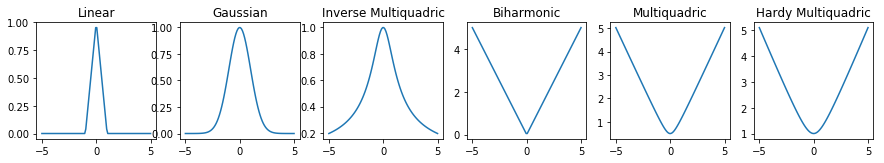

In [6]:
import numpy
from matplotlib import pyplot

# create plot figures
f = pyplot.figure(figsize=(15,15))
ax1 = f.add_subplot(6,6,1)
ax2 = f.add_subplot(6,6,2)
ax3 = f.add_subplot(6,6,3)
ax4 = f.add_subplot(6,6,4)
ax5 = f.add_subplot(6,6,5)
ax6 = f.add_subplot(6,6,6)

x = numpy.linspace(-5, 5, 100)

# Linear
ax1.title.set_text('Linear')
y = numpy.vectorize(linear)(numpy.abs(x), sigma=1)
ax1.plot(x, y)

# Inverse Multiquadric
ax3.title.set_text('Inverse Multiquadric')
y = numpy.vectorize(inverse_multiquadric)(numpy.abs(x), sigma=1)
ax3.plot(x, y)

# Gaussian
ax2.title.set_text('Gaussian')
y = numpy.vectorize(gaussian)(numpy.abs(x), sigma=1)
ax2.plot(x, y)

# Biharmonic
ax4.title.set_text('Biharmonic')
y = numpy.vectorize(biharmonic)(numpy.abs(x), sigma=2)
ax4.plot(x, y)

# Multiquadric
ax5.title.set_text('Multiquadric')
y = numpy.vectorize(multiquadric)(numpy.abs(x), sigma=2)
ax5.plot(x, y)

# Hardy Multiquadric
ax6.title.set_text('Hardy Multiquadric')
y = numpy.vectorize(hardy_multiquadric)(numpy.abs(x), sigma=1)
ax6.plot(x, y)





In [7]:
import numpy
from scipy.sparse import lil_matrix 

def rbf_solve_weights(nodes, values, sigma=1.0, distance_function=euclidean_distance, kernel_function=linear):
    
    N = len(nodes)
    A = numpy.eye(N)
    
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            A[i,j] = kernel_function(distance_function(nodes[i], nodes[j]), sigma=sigma)
    
    # solve weights 
    return numpy.linalg.solve(A, values)

def rbf(current_node, nodes, weights, sigma=1.0, distance_function=euclidean_distance, kernel_function=linear):
    
    N = len(nodes)
    A = lil_matrix((N, N))
    A.setdiag([kernel_function(distance_function(current_node, nodes[i]), sigma=sigma) for i in range(len(nodes))])
    
    return numpy.sum(A*weights, axis=0)

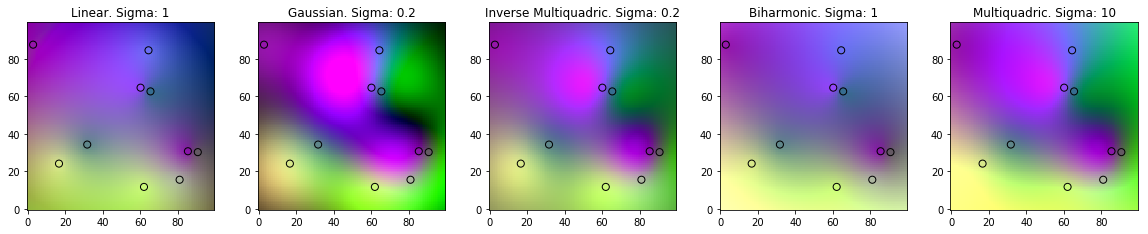

In [8]:
import numpy
from matplotlib import pyplot

# generate data
nodes = numpy.random.random((10, 2))
values = numpy.random.random((10, 3))

# create NxN grid
N = 100
ti = numpy.linspace(0, 1, N)

# create plot figures
f = pyplot.figure(figsize=(20,20))
ax1 = f.add_subplot(5,5,1)
ax2 = f.add_subplot(5,5,2)
ax3 = f.add_subplot(5,5,3)
ax4 = f.add_subplot(5,5,4)
ax5 = f.add_subplot(5,5,5)

# ======
# Linear
# ======
sigma = 1
kernel_function = linear
weights = rbf_solve_weights(nodes, values, sigma=sigma, kernel_function=kernel_function)
data = numpy.array([rbf([ti[j],ti[i]], nodes, weights, sigma=sigma, kernel_function=kernel_function) for i in range(N) for j in range(N)])

ax1.title.set_text('{}. Sigma: {}'.format('Linear', sigma))
ax1.scatter(nodes[:,0]*N, nodes[:,1]*N, s=50, c=values, edgecolor='black') # size/color
ax1.imshow(data.reshape(N,N,3), origin='lower')

# ========
# Gaussian
# ========
sigma = 0.2
kernel_function = gaussian
weights = rbf_solve_weights(nodes, values, sigma=sigma, kernel_function=kernel_function)
data = numpy.array([rbf([ti[j],ti[i]], nodes, weights, sigma=sigma, kernel_function=kernel_function) for i in range(100) for j in range(100)])

ax2.title.set_text('{}. Sigma: {}'.format('Gaussian', sigma))
ax2.scatter(nodes[:,0]*N, nodes[:,1]*N, s=50, c=values, edgecolor='black') # size/color
ax2.imshow(data.reshape(N,N,3), origin='lower')

# ====================
# Inverse Multiquadric
# ====================
sigma = 0.2
kernel_function = inverse_multiquadric
weights = rbf_solve_weights(nodes, values, sigma=sigma, kernel_function=kernel_function)
data = numpy.array([rbf([ti[j],ti[i]], nodes, weights, sigma=sigma, kernel_function=kernel_function) for i in range(100) for j in range(100)])

ax3.title.set_text('{}. Sigma: {}'.format('Inverse Multiquadric', sigma))
ax3.scatter(nodes[:,0]*N, nodes[:,1]*N, s=50, c=values, edgecolor='black') # size/color
ax3.imshow(data.reshape(N,N,3), origin='lower')

# ==========
# Biharmonic
# ==========
sigma = 1
kernel_function = biharmonic
weights = rbf_solve_weights(nodes, values, sigma=sigma, kernel_function=kernel_function)
data = numpy.array([rbf([ti[j],ti[i]], nodes, weights, sigma=sigma, kernel_function=kernel_function) for i in range(100) for j in range(100)])

ax4.title.set_text('{}. Sigma: {}'.format('Biharmonic', sigma))
ax4.scatter(nodes[:,0]*N, nodes[:,1]*N, s=50, c=values, edgecolor='black') # size/color
ax4.imshow(data.reshape(N,N,3), origin='lower')

# ============
# Multiquadric
# ============
sigma = 10
kernel_function = multiquadric
weights = rbf_solve_weights(nodes, values, sigma=sigma, kernel_function=kernel_function)
data = numpy.array([rbf([ti[j],ti[i]], nodes, weights, sigma=sigma, kernel_function=kernel_function) for i in range(100) for j in range(100)])

ax5.title.set_text('{}. Sigma: {}'.format('Multiquadric', sigma))
ax5.scatter(nodes[:,0]*N, nodes[:,1]*N, s=50, c=values, edgecolor='black') # size/color
ax5.imshow(data.reshape(N,N,3), origin='lower')

